In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

C:\Users\Sriya Nukala\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Sriya Nukala\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want t

TensorFlow Version 2.14.0


In [2]:
image_size = 224
batch_size = 32
n_classes = 5
EPOCHS = 5



filepath = 'C:/Users/Sriya Nukala/Downloads/Dataset1/gaussian_filtered_images'

classes = {0 : "No_DR", 1 : "Mild", 2 : "Moderate", 3 : "Severe", 4 : "Proliferate_DR"}

In [3]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

train_gen = datagen.flow_from_directory(
                                        filepath,
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (224, 224))

valid_gen = datagen.flow_from_directory(
                                        filepath,
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (224, 224))

test_gen = datagen.flow_from_directory(
                                        filepath,
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (224, 224))

Found 3662 images belonging to 5 classes.
Found 3662 images belonging to 5 classes.
Found 3662 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

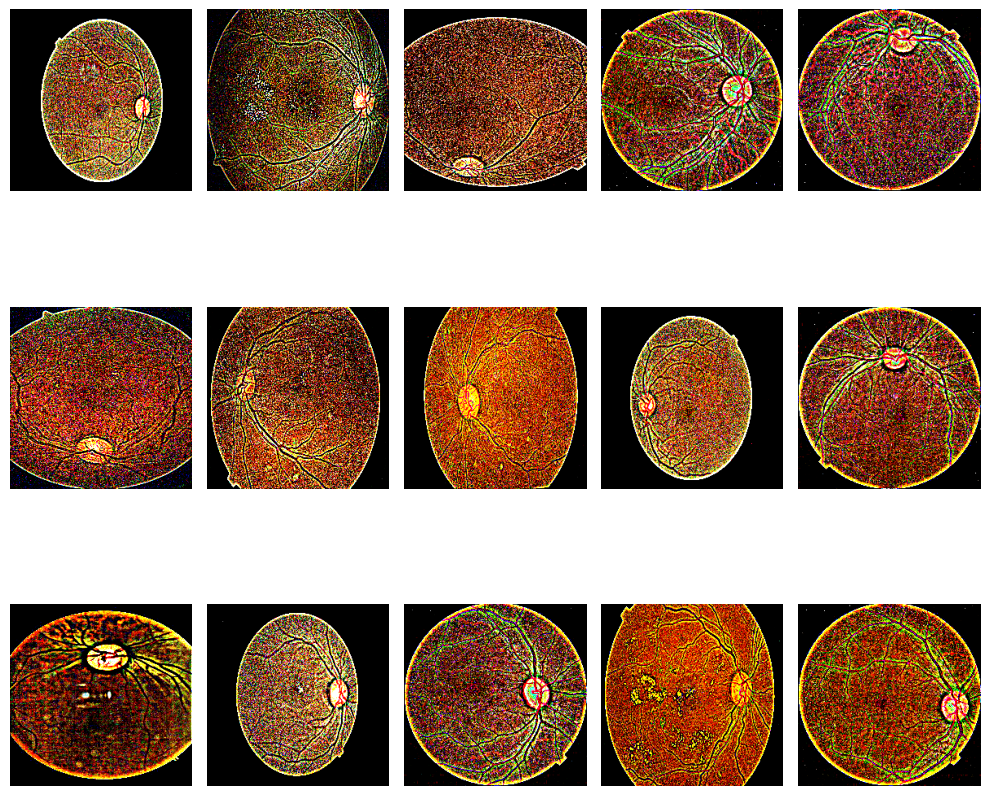

In [7]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from vit_keras import vit

In [10]:
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

In [15]:
from tensorflow.python.keras import regularizers

In [16]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu, kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                24608     
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                               

In [17]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

In [18]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = METRICS)

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                factor = 0.2,
                                                patience = 2,
                                                verbose = 1,
                                                min_delta = 1e-4,
                                                min_lr = 1e-6,
                                                mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                min_delta = 1e-4,
                                                patience = 5,
                                                mode = 'max',
                                                restore_best_weights = True,
                                                verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                 monitor = 'val_accuracy', 
                                                 verbose = 1, 
                                                 save_best_only = True,
                                                 save_weights_only = True,
                                                mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]



#model.fit(x = train_gen,validation_data = valid_gen)

In [19]:
model.fit(x = train_gen,
         steps_per_epoch = STEP_SIZE_TRAIN,
         validation_data = valid_gen,
         validation_steps = STEP_SIZE_VALID,
         epochs = EPOCHS,
         callbacks = callbacks)

Epoch 1/5
114/114 [==============================] - 2451s 21s/step - loss: 1.8113 - Accuracy: 0.3785 - AUC: 0.6905 - f1_score: 0.2827 - val_loss: 1.3195 - val_Accuracy: 0.6562 - val_AUC: 0.8733 - val_f1_score: 0.3691 - lr: 1.0000e-04
Epoch 2/5
114/114 [==============================] - 2329s 20s/step - loss: 1.4205 - Accuracy: 0.5802 - AUC: 0.8504 - f1_score: 0.3968 - val_loss: 1.2447 - val_Accuracy: 0.7473 - val_AUC: 0.9320 - val_f1_score: 0.4146 - lr: 1.0000e-04
Epoch 3/5
114/114 [==============================] - 2332s 21s/step - loss: 1.2815 - Accuracy: 0.6741 - AUC: 0.8999 - f1_score: 0.4601 - val_loss: 1.2086 - val_Accuracy: 0.7451 - val_AUC: 0.9326 - val_f1_score: 0.4350 - lr: 1.0000e-04
Epoch 4/5
114/114 [==============================] - 2332s 20s/step - loss: 1.2157 - Accuracy: 0.7212 - AUC: 0.9206 - f1_score: 0.4898 - val_loss: 1.1070 - val_Accuracy: 0.7854 - val_AUC: 0.9547 - val_f1_score: 0.4894 - lr: 1.0000e-04
Epoch 5/5
114/114 [==============================] - 2517s 2

115/115 [==============================] - 688s 6s/step
              precision    recall  f1-score   support

           0       0.12      0.12      0.12       370
           1       0.28      0.38      0.32       999
           2       0.48      0.48      0.48      1805
           3       0.05      0.02      0.03       295
           4       0.00      0.00      0.00       193

    accuracy                           0.35      3662
   macro avg       0.19      0.20      0.19      3662
weighted avg       0.33      0.35      0.34      3662



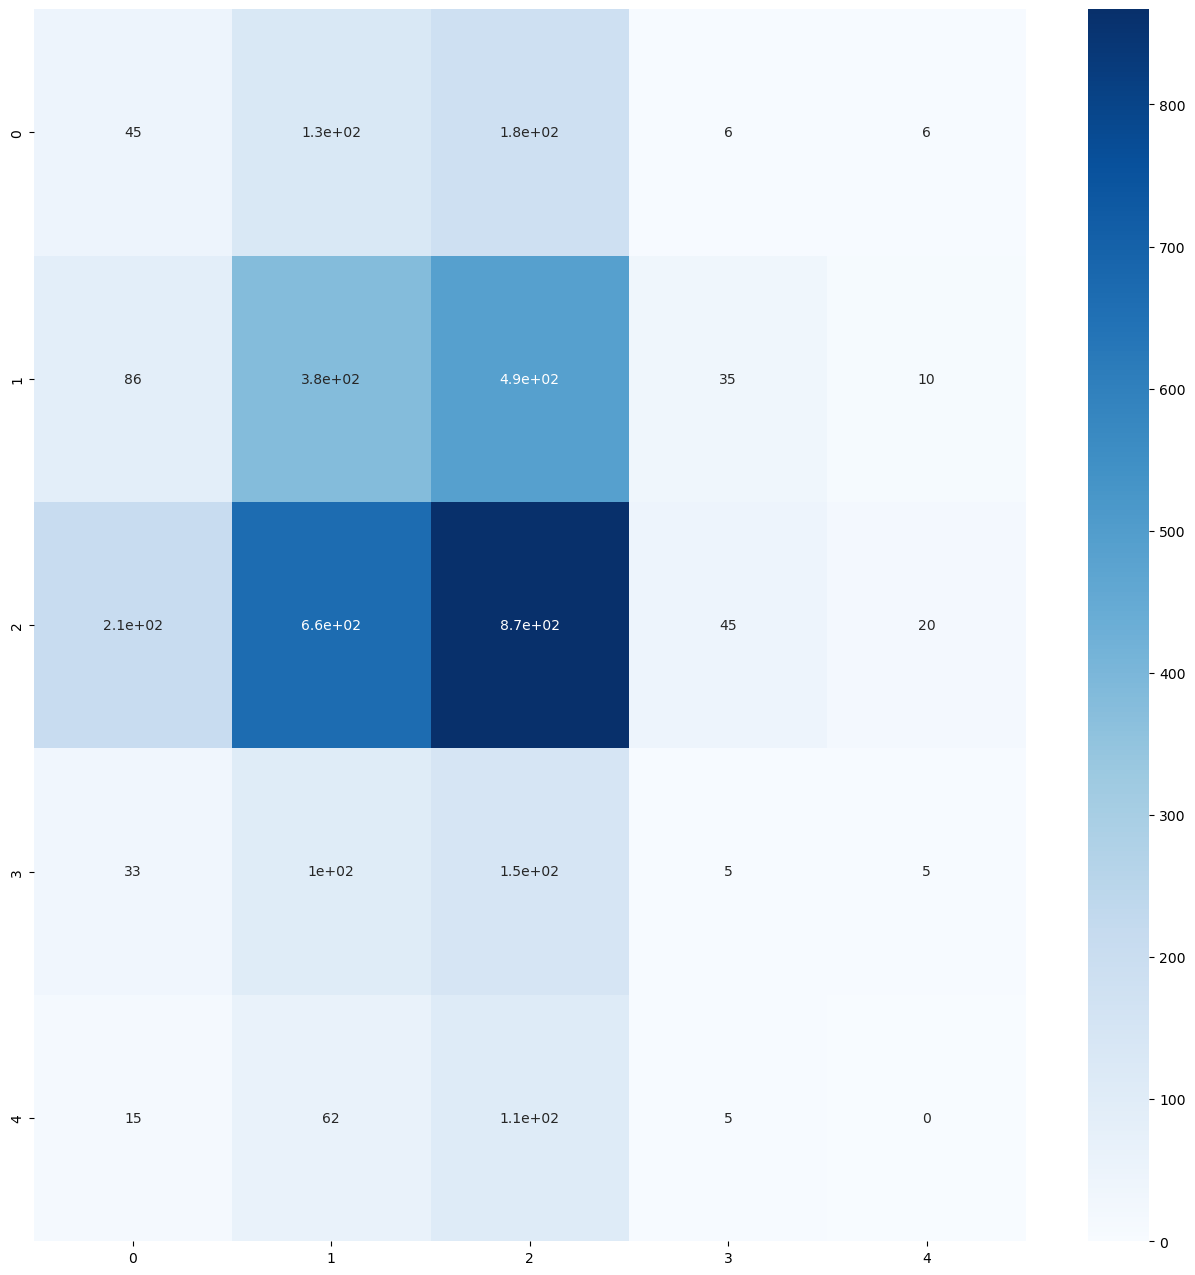

In [21]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

In [22]:
acc = np.sum(confusionmatrix.diagonal()) / np.sum(confusionmatrix)
print('Overall accuracy: {} %'.format(acc*100))

Overall accuracy: 35.41780447842709 %
